### Fitzroy Gardens dataset (Sensor readings) - Matias Miller
- 56571 rows (each row is one sensor reading) 
- 20 columns

Importerar alla saker som vi behöver.

In [1]:
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
import IPython.core.display
import geopandas
from shapely.geometry import Point
import descartes



### 1. Läs in datasettet i en variabel med hjälp av python pandas.


In [2]:
df = pd.read_csv("Sensor_readings__with_temperature__light__humidity_every_5_minutes_at_8_locations__trial__2014_to_2015_.csv", 
                 )
df.columns = ["timestamp", "mac", "boardtype", "boardid", "temp_max", "temp_min", "temp_avg", "light_max", "light_min", "light_avg", "humidity_min", "humidity_max", "humidity_avg", "model", "latitude", "longitude", "elevation", "location", "rowid", "Position"]
               
print(display(df.head(5)))

df_for_map = pd.read_csv("Sensor_readings__with_temperature__light__humidity_every_5_minutes_at_8_locations__trial__2014_to_2015_.csv", 
                 )
df_for_map.columns = ["timestamp", "mac", "boardtype", "boardid", "temp_max", "temp_min", "temp_avg", "light_max", "light_min", "light_avg", "humidity_min", "humidity_max", "humidity_avg", "model", "latitude", "longitude", "elevation", "location", "rowid", "Position"]
               








,timestamp,mac,boardtype,boardid,temp_max,temp_min,temp_avg,light_max,light_min,light_avg,humidity_min,humidity_max,humidity_avg,model,latitude,longitude,elevation,location,rowid,Position
0,12/15/2014 01:40:00 AM,0013a20040b4b755,1,508,21.6,21.6,21.6,96.4,96.4,96.4,41.2,41.2,41.2,ENV,-37.813408,144.979492,30.10,Fitzroy Gardens,508-20141215014000,NaN
1,12/15/2014 01:40:00 AM,0013a20040b516ed,1,505,23.2,23.2,23.2,93.5,93.5,93.5,48.3,48.3,48.3,ENV,-37.813073,144.980406,29.91,Fitzroy Gardens,505-20141215014000,NaN
2,12/15/2014 01:45:00 AM,0013a20040b516f6,1,507,21.6,21.6,21.6,97.2,97.2,97.2,44.8,44.8,44.8,ENV,-37.814922,144.982258,38.79,Fitzroy Gardens,507-20141215014500,NaN
3,12/15/2014 01:45:00 AM,0013a20040b5b318,1,502,21.3,21.3,21.3,97.4,97.4,97.4,45.3,45.3,45.3,ENV,-37.814610,144.979018,22.57,Fitzroy Gardens,502-20141215014500,NaN
4,12/15/2014 01:45:00 AM,0013a20040b315ec,1,501,22.9,22.9,22.9,97.4,97.4,97.4,43.1,43.1,43.1,ENV,-37.814808,144.980999,29.96,Fitzroy Gardens,501-20141215014500,NaN


None


### 2.

Strukturen på datasetet ser man ju ganska bra när man har läst in all data och visualiserat den i en tabell. Datasetet har 56571 rader och 20 kolumner med olika data som ger oss information om varje "sensor reading".
Första kolumnen innehåller tiden när inläsningen har tagit plats.

Datasettet har också ganska många problem..
- Inläsningarna är super irregulära, sensorer har flera dagars pauser, tiden hoppar etc.. strukturen på hela datasettet kunde ju göras mycket bättre, och dessutom hoppar sensorernas groupid över 503 och 504 av ingen ordentlig orsak vilket också gör det svårare att handskas me datasetet.
- Min och max värden för alla sensortyperna är irrelevanta, dom är exakt samma som avg_ värdena vilket är ganska konstigt i min åsikt.
- På framsidan av deras dokumentatition (och i dokumentationen) säger dom att sensorerna befinner sig på 8 olika platser, fast det finns 9 sensorer alltsomallt.. knappast ligger 2 av dom på varandra.


Kolumner som är kopplade med varandra:
- temp_max, temp_min och temp_avg är ju självklart kopplade och beroende av varandra.
- light_max, light_min och light_avg, samma sak här.
- humidity_max, humidity_min och humidity_avg, dom hänger också ihop.
- latitude, longitude, location ->  pekar på platsen där sensorn befinner sig, vilket i detta fall är Fitzroy Gardens och parken där alla sensorerna finns.
- Kolumnerna som man kunde tänka sig att "droppa" och som jag själv inte tycker är värst relevanta är: mac, boardtype, alla max och min, och hålla avg för att den ger oss en riktigt bra average värde, model, lat, long, rowid och position.

### 3.

Med hjälp av df.drop så valde jag vilka kolumner som jag rensar bort för att bara ha framme den mest relevanta datan, i min åsikt. 


In [3]:
df.drop(columns= ["mac", "boardtype", "temp_max", "temp_min", "light_max", "light_min", "humidity_min", "humidity_max", "model", "latitude", "longitude", "rowid", "Position", "elevation"], inplace=True)

print(display(df.head(5)))

,timestamp,boardid,temp_avg,light_avg,humidity_avg,location
0,12/15/2014 01:40:00 AM,508,21.6,96.4,41.2,Fitzroy Gardens
1,12/15/2014 01:40:00 AM,505,23.2,93.5,48.3,Fitzroy Gardens
2,12/15/2014 01:45:00 AM,507,21.6,97.2,44.8,Fitzroy Gardens
3,12/15/2014 01:45:00 AM,502,21.3,97.4,45.3,Fitzroy Gardens
4,12/15/2014 01:45:00 AM,501,22.9,97.4,43.1,Fitzroy Gardens


None


### Medel temperatur

Jag valde att visa 1 värde per sensor, per dag. Så jag grupperade sensorerna enligt sensor och enligt deras "timestamp" så att jag kunde räkna medeltalet för varje sensor för 1 dag. Sensorernas inläsning varierade från ungefär 80-110 inläsningar i dagen och det gjorde mina linjediagram helt läsbara.

På x axeln finns tiden och på Y-axeln värdet för vad som har mätts, alla 9 sensorer är ritade i samma diagram.

/Users/matias/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


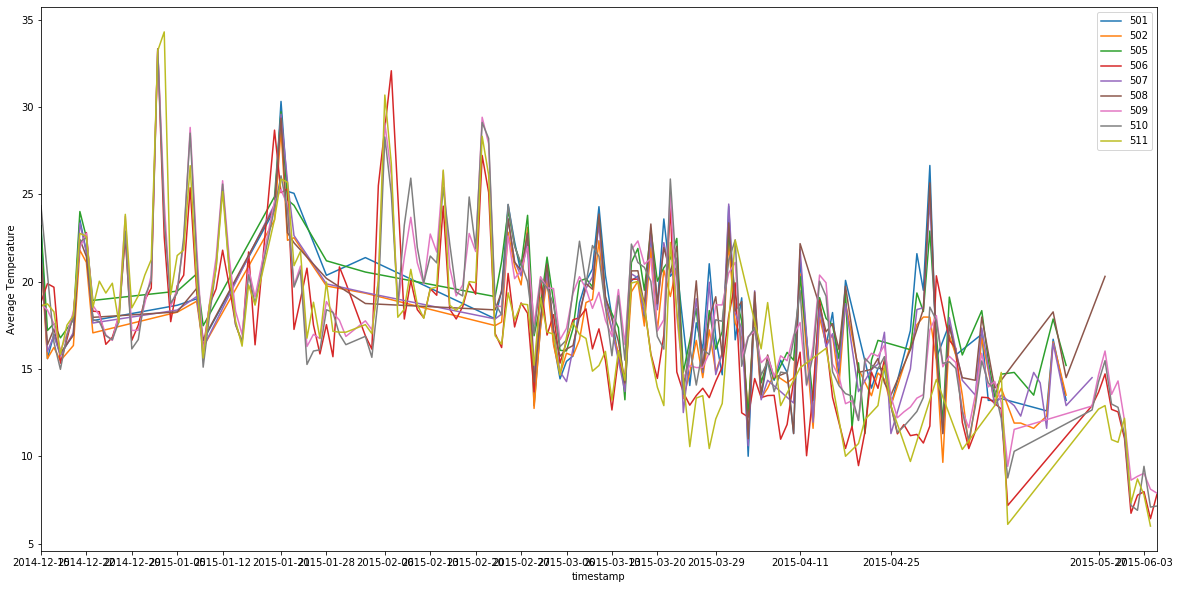

In [4]:
#TEMP
df['timestamp']  = pd.to_datetime(df['timestamp'])


fig, ax = plt.subplots()

for key, grp in df.groupby(['boardid']):
    
    grp['timestamp'] = grp['timestamp'].dt.date
    mean = grp.groupby(['timestamp', 'boardid'], as_index=False)['temp_avg'].mean()
    
    ax = mean.plot(ax=ax, kind='line', x='timestamp', y='temp_avg', label=key, figsize=[20, 10])

ax.set_ylabel("Average Temperature")
ax.set_xticks(mean['timestamp'][::7])
#ax.set_xticklabels(mean['timestamp'], rotation=90)
mean.max()

plt.show()


### Medeltemperatur med area diagram

Här experimenterade med hur det skulle se ut med ett area diagram, men som man ser så fattar man ingenting och i min åsikt är det helt onödigt, linje diagrammet är nog bäst.

/Users/matias/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


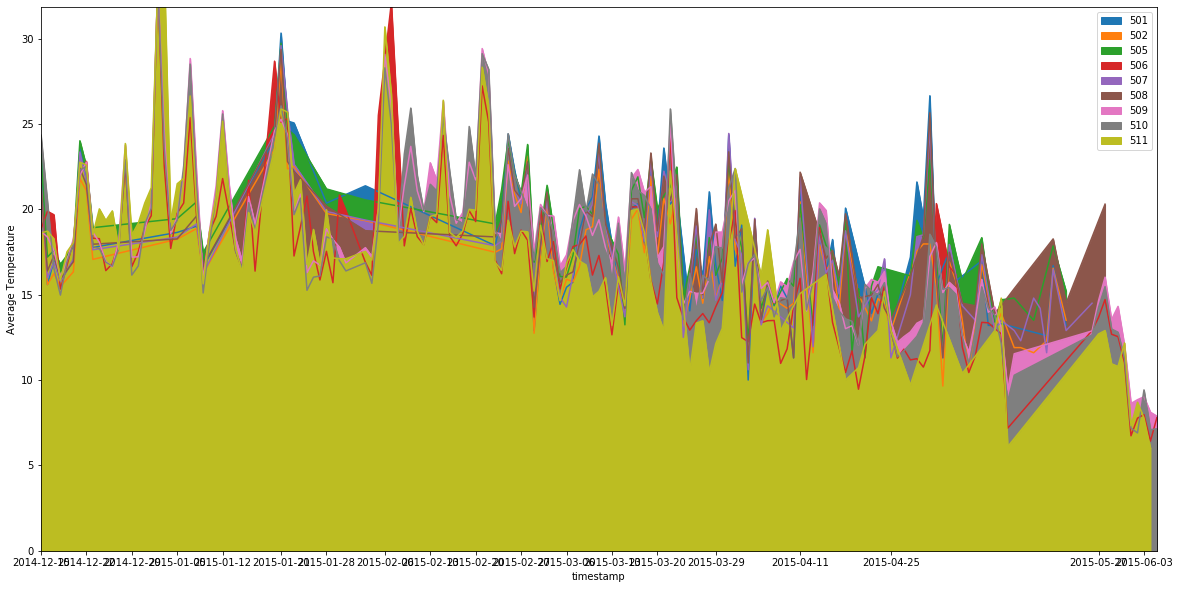

In [5]:
#TEMP testnig av area iställe för linje
df['timestamp']  = pd.to_datetime(df['timestamp'])


fig, ax = plt.subplots()

for key, grp in df.groupby(['boardid']):
    
    grp['timestamp'] = grp['timestamp'].dt.date
    mean = grp.groupby(['timestamp', 'boardid'], as_index=False)['temp_avg'].mean()
    #print(mean)
    ax = mean.plot(ax=ax, kind='area', x='timestamp', y='temp_avg', label=key, figsize=[20, 10])

ax.set_ylabel("Average Temperature")
ax.set_xticks(mean['timestamp'][::7])
#ax.set_xticklabels(mean['timestamp'], rotation=90)
mean.max()

plt.show()


### Medel humiditet

Samma princip som i temperatur diagrammet, jag räknade medeltals humidititen per dag och ritade ut så att den visar 1 värde per dag.

/Users/matias/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


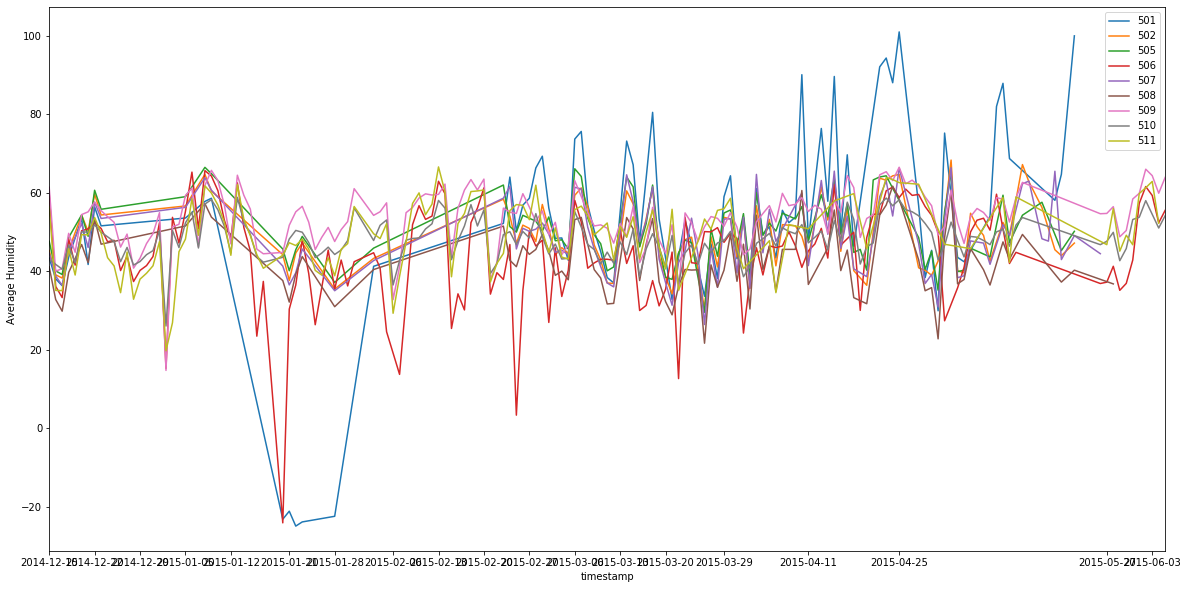

In [6]:
#HUMIDITY
df['timestamp']  = pd.to_datetime(df['timestamp'])


fig, ax = plt.subplots()

for key, grp in df.groupby(['boardid']):
    
    grp['timestamp'] = grp['timestamp'].dt.date
    mean = grp.groupby(['timestamp', 'boardid'], as_index=False)['humidity_avg'].mean()
    #print(mean)
    ax = mean.plot(ax=ax, kind='line', x='timestamp', y='humidity_avg', label=key, figsize=[20, 10])
    
    

ax.set_ylabel("Average Humidity")
ax.set_xticks(mean['timestamp'][::7])
#ax.set_xticklabels(mean['timestamp'], rotation=90)



plt.show()

### Medel ljusnivån 

Samma sak som i temp och humiditet. Detta diagram blev ganska "råddigt" och kanske lite svårt att läsa, borde kanske ha räknar medeltalet av inläsnigarna per vecka eller något dylikt, men jag bestämde mig att göra såhär.

/Users/matias/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


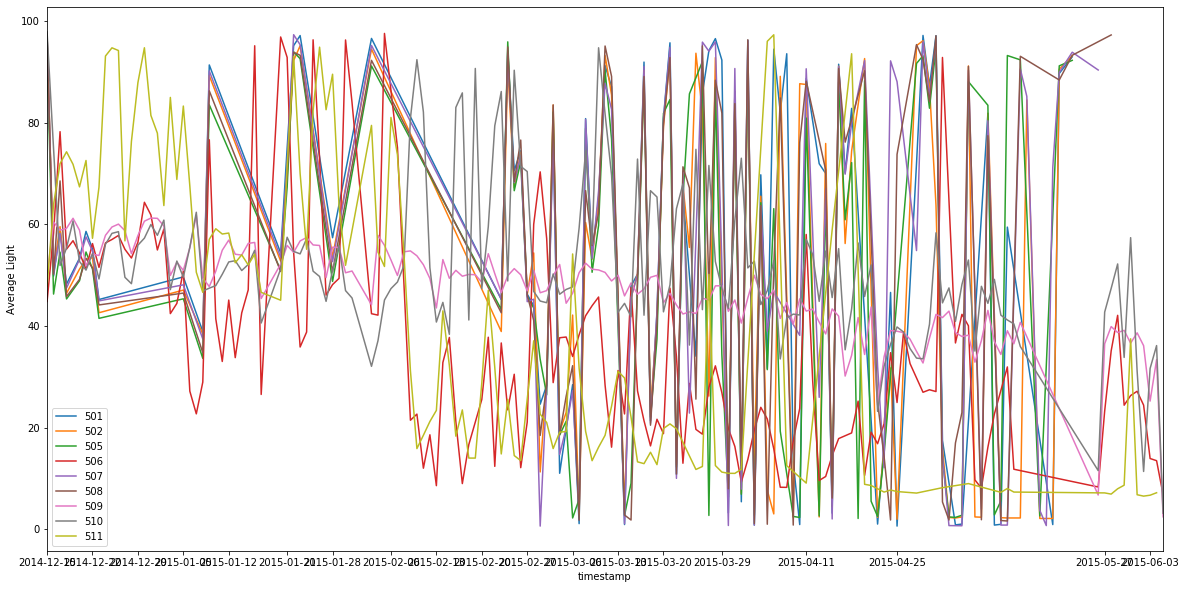

In [7]:
#LIGHT
df['timestamp']  = pd.to_datetime(df['timestamp'])


fig, ax = plt.subplots()

for key, grp in df.groupby(['boardid']):
    
    grp['timestamp'] = grp['timestamp'].dt.date
    mean = grp.groupby(['timestamp', 'boardid'], as_index=False)['light_avg'].mean()
    #mean = mean[::2] #use this if you want every other value
    ax = mean.plot(ax=ax, kind='line', x='timestamp', y='light_avg', label=key, figsize=[20, 10])
    
ax.set_ylabel("Average Light")
ax.set_xticks(mean['timestamp'][::7])
#ax.set_xticklabels(mean['timestamp'], rotation=90)

plt.show()




### 5.
### Medelvärdet och medianen (manuellt) för varje sensortyp och sensor

Jag började med att först gruppera sensorerna enligt deras boardid och plussa ihop temp, light och humid kolumnerna för att få summan av alla värden per sensor. 
Med att printa sumDf får vi en tabell där alla värden är plussade ihop, per sensor.

För att få mängden rader per sensor gjorde jag en lista och sedan loopar ja igenom alla sensorer skillt och fylla den tomma listan med len(grp) för att få mängden rader som vi kan dela med summan av alla rader för att få medelvärdet.

För att manuellt ta medelvärdet av alla sensorer skillt, för varsin kategori så använder vi .loc funktionen för att välja rätt sensor och rätta kolumnerna och dela dom med antalet rader som finns för varsin sensor och sen printar vi tabellen och konstaterar att den ser likadan ut som vårt "facit" medelvärde som finns nedanför, så vi har gjort rätt.



In [8]:
#MEDELVÄRDET
def average():
    #Vi börjar med att summa ihop alla värden som hör till varsin sensor med att använda sum()
    sumDf = df.groupby(['boardid'], as_index=False).sum()
    #print(display(sumDf))

    #gör en lista som ska hålla antalet rader för varsin sensor, sen loopar vi och appendar värdena till listan
    amountOfRows = []

    for key, grp in df.groupby(['boardid']):

        amountOfRows.append(len(grp))

    #printar listan för att kolla att allting stämmer, alla rader är med .. totalt 56570
    print(amountOfRows)

    #Sen för att manuellt ta medelvärdet av alla sensorer skillt, för varsin kategori så använder vi .loc funktionen
    #för att välja rätt sensor och rätta kolumnerna och dela dom med antalet rader som finns för varsin sensor..
    #och sen printar vi tabellen och konstaterar att det fungerar som det ska.
    sumDf.loc[sumDf['boardid'] == 501, ['temp_avg', 'light_avg', 'humidity_avg']] = sumDf.loc[[0], ['temp_avg', 'light_avg', 'humidity_avg']] / amountOfRows[0]
    sumDf.loc[sumDf['boardid'] == 502, ['temp_avg', 'light_avg', 'humidity_avg']] = sumDf.loc[[1], ['temp_avg', 'light_avg', 'humidity_avg']] / amountOfRows[1]
    sumDf.loc[sumDf['boardid'] == 505, ['temp_avg', 'light_avg', 'humidity_avg']] = sumDf.loc[[2], ['temp_avg', 'light_avg', 'humidity_avg']] / amountOfRows[2]
    sumDf.loc[sumDf['boardid'] == 506, ['temp_avg', 'light_avg', 'humidity_avg']] = sumDf.loc[[3], ['temp_avg', 'light_avg', 'humidity_avg']] / amountOfRows[3]
    sumDf.loc[sumDf['boardid'] == 507, ['temp_avg', 'light_avg', 'humidity_avg']] = sumDf.loc[[4], ['temp_avg', 'light_avg', 'humidity_avg']] / amountOfRows[4]
    sumDf.loc[sumDf['boardid'] == 508, ['temp_avg', 'light_avg', 'humidity_avg']] = sumDf.loc[[5], ['temp_avg', 'light_avg', 'humidity_avg']] / amountOfRows[5]
    sumDf.loc[sumDf['boardid'] == 509, ['temp_avg', 'light_avg', 'humidity_avg']] = sumDf.loc[[6], ['temp_avg', 'light_avg', 'humidity_avg']] / amountOfRows[6]
    sumDf.loc[sumDf['boardid'] == 510, ['temp_avg', 'light_avg', 'humidity_avg']] = sumDf.loc[[7], ['temp_avg', 'light_avg', 'humidity_avg']] / amountOfRows[7]
    sumDf.loc[sumDf['boardid'] == 511, ['temp_avg', 'light_avg', 'humidity_avg']] = sumDf.loc[[8], ['temp_avg', 'light_avg', 'humidity_avg']] / amountOfRows[8]


    print(display(sumDf.round(3)))
    
average()

    
    

[2903, 2725, 2915, 6626, 2918, 2728, 19119, 12038, 4598]


,boardid,temp_avg,light_avg,humidity_avg
0,501,19.862,55.597,44.314
1,502,19.029,54.328,48.682
2,505,20.421,52.083,50.382
3,506,16.885,36.559,46.118
4,507,19.734,55.154,47.535
5,508,19.912,54.475,42.270
6,509,18.178,47.437,53.527
7,510,18.089,50.297,48.385
8,511,19.509,49.594,48.434


None


### Facit för medelvärdet med .mean() funtkionen

In [9]:
#Facit för att kolla att vi har räknat rätt
def averageFacit():
    averageFacit = df.groupby(['boardid'], as_index=False).mean()
    print(display(averageFacit.round(3)))

    #medelvärde = summan av raderna / antal rader
    
averageFacit()

,boardid,temp_avg,light_avg,humidity_avg
0,501,19.862,55.597,44.314
1,502,19.029,54.328,48.682
2,505,20.421,52.083,50.382
3,506,16.885,36.559,46.118
4,507,19.734,55.154,47.535
5,508,19.912,54.475,42.270
6,509,18.178,47.437,53.527
7,510,18.089,50.297,48.385
8,511,19.509,49.594,48.434


None



### Median facit, median()

In [10]:
def medianFacit():
    medianFacit = df.groupby(['boardid'], as_index=False).median()
    print(display(medianFacit.round(3)))

    #medelvärde = summan av raderna / antal rader
    
medianFacit()

,boardid,temp_avg,light_avg,humidity_avg
0,501,19.0,88.20,47.3
1,502,18.1,84.60,49.9
2,505,20.0,78.30,51.0
3,506,16.5,8.50,48.6
4,507,19.0,86.80,48.3
5,508,19.0,83.25,43.3
6,509,17.4,29.10,56.2
7,510,17.1,73.75,49.2
8,511,18.7,13.55,50.2


None


### Median funktionen (manuellt)

Jag gjorde en funktion som räknar medianen som jag använde på mina egna listor som innehåller värden av temp, light och humidity skillt.

Sen gör vi en ny dataframe på basis av mina nya listor som innehåller median värden -> sen kan vi jämföra min självgjorda dataframe med facit så kan vi konstatera att jag får samma resultat.

In [11]:

#Median funktionen som räknar medianen av en lista.
def median(lst):
    n = len(lst)
    if n < 1:
            return None
    if n % 2 == 1:
            return sorted(lst)[n//2]
    else:
            return sum(sorted(lst)[n//2-1:n//2+1])/2.0

#Jag gjorde 3 listor för varje värde som sensorn plockar upp
templist = []
lightlist = []
humidlist = []
sensorlist = []

#Vi loopar igen igenom för att få alla sensorer skillt
for key, grp in df.groupby(['boardid']):
    
    #Sorterar värderna i storleks ordning enligt typen
    temp = grp.sort_values(by=['temp_avg'], ascending=True)
    light = grp.sort_values(by=['light_avg'], ascending=True)
    humid = grp.sort_values(by=['humidity_avg'], ascending=True)
    
    #Lägger till vårt medianvärde med hjälp av vår median() funktion in i våra listor
    sensorlist.append(grp.iloc[0]['boardid'])
    templist.append(median(temp['temp_avg']))
    lightlist.append(median(light['light_avg']))
    humidlist.append(median(humid['humidity_avg']))
    
#Bygger en ny dataframe på basis av våra värden och printar den
myframe = pd.DataFrame({"Sensor":sensorlist, "Temperature_Median":templist,"Light_Median":lightlist, "Humidity_Median": humidlist})
print (display(myframe))


,Sensor,Temperature_Median,Light_Median,Humidity_Median
0,501,19.0,88.20,47.3
1,502,18.1,84.60,49.9
2,505,20.0,78.30,51.0
3,506,16.5,8.50,48.6
4,507,19.0,86.80,48.3
5,508,19.0,83.25,43.3
6,509,17.4,29.10,56.2
7,510,17.1,73.75,49.2
8,511,18.7,13.55,50.2


None


## 

### 6. 

Jag bestämde mig att rita en autokorrelation plot och lag plot baserad på alla sensorers inläsningar av temperaturen under de 2 första dagarna av inläsning, alltså 15.12 - 16.12, vilket innebär 1109 inläsningar av temperatur värden.

AxesSubplot(0.125,0.125;0.775x0.755)


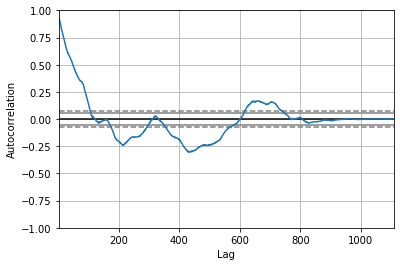

In [12]:
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

df['timestamp']  = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.date

autocorrelation = df.sort_values(by=['timestamp'])

##15.12-16.12 (1109 readings)
print(autocorrelation_plot(autocorrelation.iloc[1:1110]['temp_avg']))

    
    
    
    

In [13]:
print(lag_plot(asd.iloc[1:1110]['temp_avg']))


NameError: name 'asd' is not defined

### Bonus uppgift - medeltemperaturen för 12:00 och 00:00 på veckoslut, ritat på en karta med hjälp av sensorernas koordinater.

Jag använde mig av dt.weekday_name för att få fram vilken dag vilken inläsning är, och efter det så filtrerade jag bort alla andra dagar än Fredag, Lördag och Söndag.

Det konstiga med det här datasetet som jag redan märkte tidigare är att temperaturerna är mycket konstiga, t.ex medeltemperaturen är högre kl 00:00:00 än på dagen 12:00:00 vilket är mycket konstigt, är det fel på sensorerna eller vad är problemet?

Koden är kommenterad så man kan följa med bättre.

In [ ]:
#Vi använder oss av en annan dataframe så vi får in long och lat kolumnerna.
df_for_map.drop(columns= ["mac", "boardtype", "temp_max", "temp_min", "light_max", "light_min", "humidity_min", "humidity_max", "model", "rowid", "Position", "elevation"], inplace=True)


In [ ]:


#Vi konverterar vårt datum igen till datetime format.
df_for_map['timestamp']  = pd.to_datetime(df_for_map['timestamp'])
df_for_map['timestamp'] = pd.to_datetime(df_for_map['timestamp'], format = '%Y-%m-%d %H:%M:%S')

#Vi gör en ny kolumn som markerar vilken dag varje inläsning är.
df_for_map['Day of Week'] = df_for_map['timestamp'].dt.weekday_name


In [ ]:
#Vi filtrerar bort alla andra dagar än Fredag, Lördag och Söndag..
df_for_map = df_for_map[df_for_map['Day of Week'].isin(['Friday', 'Saturday', 'Sunday'])]

#Testar att det funkar med print
#print(display(df_for_map))

#Vi gör timestamp kolumnen till index för att kunna använda oss av df.at_time() funktionen vilken ger oss möjligheten
#att sortera vårt dataset på basis av klockslag.
df_for_map_index = df_for_map.set_index(['timestamp'])

#Vi gör 2 olika dataframes som är sorterade enligt middag och midnatt.
daytimevalues = df_for_map_index.at_time('12:00')
midnightvalues = df_for_map_index.at_time('00:00')

#Räknar medeltalet för alla 12:00 värden och printar för att se om det fungerar.
daytimeaverages = daytimevalues.groupby(['boardid'], as_index=False).mean()
print(display(daytimeaverages))

#Samma sak för midnatt värden.
midnightaverages = midnightvalues.groupby(['boardid'], as_index=False).mean()
print(display(midnightaverages))



In [ ]:
#För att kunna rita våra värden på kartan så gör vi en ny kolumn som är baserad på lon och lat kolumnerna, 
#vilka vi kombinerar för båda dataseten (midnatt och middag)

daytimeaverages['Coordinates'] = list(zip(daytimeaverages.longitude, daytimeaverages.latitude))

daytimeaverages['Coordinates'] = daytimeaverages['Coordinates'].apply(Point)

midnightaverages['Coordinates'] = list(zip(midnightaverages.longitude, midnightaverages.latitude))

midnightaverages['Coordinates'] = midnightaverages['Coordinates'].apply(Point)

#Vi använder oss av geopandas GeoDataFrame för att göra en variabel som innehåller våra koordinater för kartan.
day = geopandas.GeoDataFrame(daytimeaverages, geometry='Coordinates')
night = geopandas.GeoDataFrame(midnightaverages, geometry='Coordinates')

#Jag laddade ner en aus_poas.php fil som innehåller en karta för alla postkoder i Australia, vi läser in den.
cities = geopandas.read_file('aus_poas.shp')

#Jag tog reda på att Melbourne har postkoder från 3000-3700 så det var bara och testa sig fram vilka som är runt 
#den arean som vi vill visa.
melb = cities.query('code >= 3000 & code <= 3008')

#Vi plottar vår karta.
ax = melb.plot(figsize = [50,120], edgecolor='black')

#Jag använder mig av en for loop som loopar igenom koordinaterna och temperaturvärden för att få värden
#ner på kartan på rätt plats, jag använder mig av ax.annotate för att få texten där var jag vill ha den.
#(Lite kanske problematiskt för att sensorerna är så nära varandra att texten blir kanske lite på varandra, men 
#det fungerar)
for i,j,temp, sensor in zip(daytimeaverages.longitude,daytimeaverages.latitude, daytimeaverages.temp_avg.round(2), daytimeaverages.boardid):
    print(sensor, temp)
    ax.annotate((str(temp)),xy=(i,j), fontsize=15)
print("------------")
# Sen plottar jag min geopandas karta med sensorerna + värden. (DAG VÄRDEN)
print("TEMPERATURES FOR EVERY SENSOR AT 12:00 MIDDAY PLOTTED AT THEIR RESPECTIVE COORDINATES: ")
day.plot(ax=ax, color='red')

plt.show()

In [ ]:
#Och här gör vi samma sak men använder oss av midnatt värden.

ax = melb.plot(figsize = [50,120], edgecolor='black')

for i,j,temp, sensor in zip(midnightaverages.longitude,midnightaverages.latitude, midnightaverages.temp_avg.round(2), midnightaverages.boardid):
    print(sensor, temp)
    ax.annotate(str(temp),xy=(i,j), fontsize=25)
    
print("------------")
 
print("TEMPERATURES FOR EVERY SENSOR AT 00:00 MIDNIGHT PLOTTED AT THEIR RESPECTIVE COORDINATES: ")

# We can now plot our GeoDataFrame.
night.plot(ax=ax, color='black')

plt.show()